In [1]:
import os
import sys
import pickle
import numpy as np
import igraph as ig
import pandas as pd
import matplotlib.pyplot as plt
from plot_auxiliary import *

from mpl_settings_v3 import *

from auxiliary import get_base_network_name, supported_attacks, get_property_file_name, simple_props
from auxiliary import get_edge_weights, get_number_of_nodes, read_data_file, getLinearReg

In [2]:
net_type = 'DT'
param = 'param'

size = 128

min_seed = 0
max_seed = 10
seeds = range(min_seed, max_seed)
n_seeds = max_seed - min_seed

N = get_number_of_nodes(net_type, size)

attacks = ['BtwU']

dfs_dict = {}
for attack in attacks:
    print(attack)
    dir_name = os.path.join('..', 'networks', net_type)
    base_net_name, base_net_name_size = get_base_network_name(net_type, size, param)
    base_net_dir = os.path.join(dir_name, base_net_name, base_net_name_size)

    perc_dfs = {}
    perc_dfs[N] = load_dataframe(net_type, N, param, attack)
    
    dfs = []
    for k, seed in enumerate(seeds):

        net_name = base_net_name_size + '_{:05d}'.format(seed)
        net_dir = os.path.join(base_net_dir, net_name)
        attack_dir = os.path.join(net_dir, attack)

        properties_file = os.path.join(attack_dir, 'properties.pickle')
        if not os.path.isfile(properties_file):
            continue
        with open(properties_file, 'rb') as f:
            data = pickle.load(f)
        df = pd.DataFrame(data)
        df['f'] = df.index.values / N
        dfs.append(df)
    
    dfs_dict[attack] = dfs

BtwU


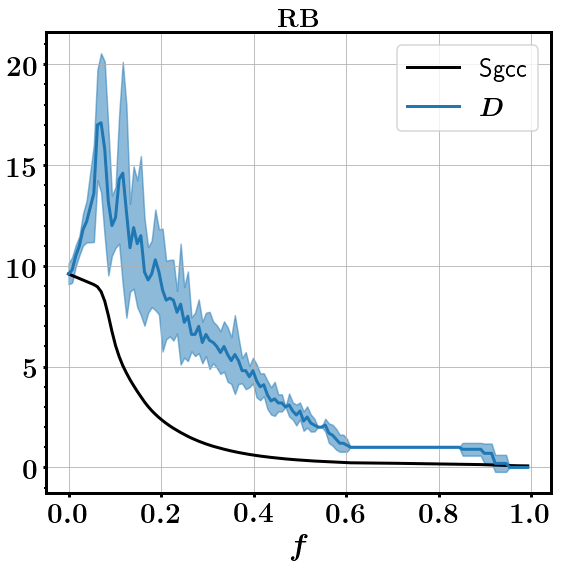

In [3]:
ncols = len(attacks)
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 8*nrows), ncols=ncols, nrows=nrows)

if ncols == 1:
    axes = np.array([axes])

for i, attack in enumerate(attacks):
    dfs = dfs_dict[attack]
    
    df = pd.concat(dfs)
    df_std = df.groupby(by='f').std()
    df = df.groupby(by='f').mean()

    X = df.index

    ax = axes[i]
    ax.set_title(attack_dict[attack], fontsize=26)
    ax.grid(True)
    ax.set_xlabel(r'$f$')
    #ax.set_yticks(range(13))
    ax.plot(perc_dfs[N].f, perc_dfs[N].Sgcc*df.D[0], color='k')
    
    ax.plot(X, df.D, label=r'$D$')
    y1 = df.D - df_std.D
    y2 = df.D + df_std.D
    ax.fill_between(X, y1, y2, color='C0', alpha=0.5)  

    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
dfs_dict = {}

In [55]:
net_type = 'DT'
param = 'param'

sizes = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
min_seed = 0
max_seed = 10000
seeds = range(min_seed, max_seed)
nseeds = max_seed - min_seed

attacks = ['BtwU']

perc_dfs = {}
for size in sizes:
    print(size)
    dir_name = os.path.join('..', 'networks', net_type)
    base_net_name, base_net_name_size = get_base_network_name(net_type, size, param)
    base_net_dir = os.path.join(dir_name, base_net_name, base_net_name_size)
    
    rc_props_output_file = os.path.join(base_net_dir, 'rc_properties_nSeeds{:d}.csv'.format(nseeds))
    if os.path.isfile(rc_props_output_file):
        continue

    perc_dfs[size] = load_dataframe(net_type, size, param, attack)
    dfs_dict[size] = pd.read_csv(rc_props_output_file)

128
256
512
1024
2048
4096
8192
16384


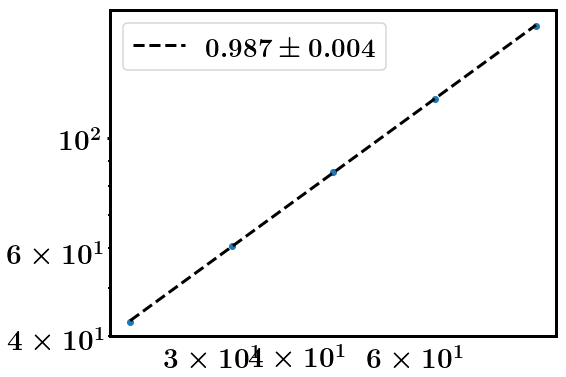

In [56]:
d_values = []
for size in sizes:
    df = dfs_dict[size]
    d_values.append(df.D.mean())
    
fig, ax = plt.subplots(figsize=(8,6))

ax.set_xscale('log')
ax.set_yscale('log')

X = np.sqrt(sizes)[-6:-1]
Y = np.array(d_values)[-6:-1]

ax.plot(X, Y, 'o')

Y_pred, slope, y_err = getLinearReg(X, Y)    
c = Y[0] / X[0]**slope
label = r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
ax.plot(X, Y_pred, '--', color='k', label=label)
ax.legend()

plt.show()

In [53]:
for size in sizes:
    print(size, dfs_dict[size].shape[0])#, dfs_dict[size].isnull().sum())

4096 9997


In [35]:
net_types = ['DT', 'PDT', 'MR']
params = {
    'DT': 'param',
    'PDT': 'param',
    'MR': 'k6.00'
}

attacks = ['BtwU', 'Btw']
networks_dir = os.path.join('..', 'networks')

seeds_dict = {
    512: range(0, 100),
    1024: range(0, 100),
    2048: range(0, 100),
    #4096: range(0, 10),
    #8192: range(0, 10)
}

sizes = [512, 1024, 2048]#, 4096, 8192]


for net_type in net_types:
    print(net_type)
    param = params[net_type]
    btw_dist_dict[net_type] = {'initial': {}, 'rc_BtwU': {}, 'rc_Btw': {}}
    for attack in attacks:
        print(attack)
        for size in sizes:
            print(size)

            dir_name = os.path.join('..', 'networks', net_type)
            base_net_name, base_net_name_size = get_base_network_name(net_type, size, param)
            base_net_dir = os.path.join(dir_name, base_net_name, base_net_name_size)

            initial_btw_dist = []
            rc_btw_dist = []
            seeds = seeds_dict[size]
            for k, seed in enumerate(seeds):

                net_name = base_net_name_size + '_{:05d}'.format(seed)
                net_dir = os.path.join(base_net_dir, net_name)
                btw_attack_dir = os.path.join(net_dir, 'Btw')
                attack_dir = os.path.join(net_dir, attack)

                if attack == 'Btw':
                    try:
                        btw_dist = read_data_file(
                            btw_attack_dir, 'initial_centrality', reader='numpy'
                        ).tolist()
                    except:
                        continue
                    initial_btw_dist = initial_btw_dist + btw_dist      

                properties_file = os.path.join(attack_dir, 'rc_properties.pickle')
                if not os.path.isfile(properties_file):
                    print(properties_file)
                    continue
                with open(properties_file, 'rb') as f:
                    data = pickle.load(f)
                rc_btw_dist = rc_btw_dist + data['Btw_dist']
            if attack == 'Btw':
                btw_dist_dict[net_type]['initial'][size] = np.array(initial_btw_dist)
            btw_dist_dict[net_type]['rc_' + attack][size] = np.array(rc_btw_dist)

    for size in sizes:
        print(
            size, btw_dist_dict[net_type]['initial'][size].shape[0], 
            btw_dist_dict[net_type]['rc_BtwU'][size].shape[0], 
            btw_dist_dict[net_type]['rc_Btw'][size].shape[0]
        )

DT
BtwU
512
1024
2048
Btw
512
1024
2048
512 51200 48102 41621
1024 102400 97450 86818
2048 204800 197386 179528
PDT
BtwU
512
1024
2048
Btw
512
1024
2048
512 51200 45832 38924
1024 102400 93304 80538
2048 204800 189504 166108
MR
BtwU
512
1024
2048
Btw
512
1024
2048
512 51200 50848 48180
1024 102400 101920 96565
2048 204800 204040 192066


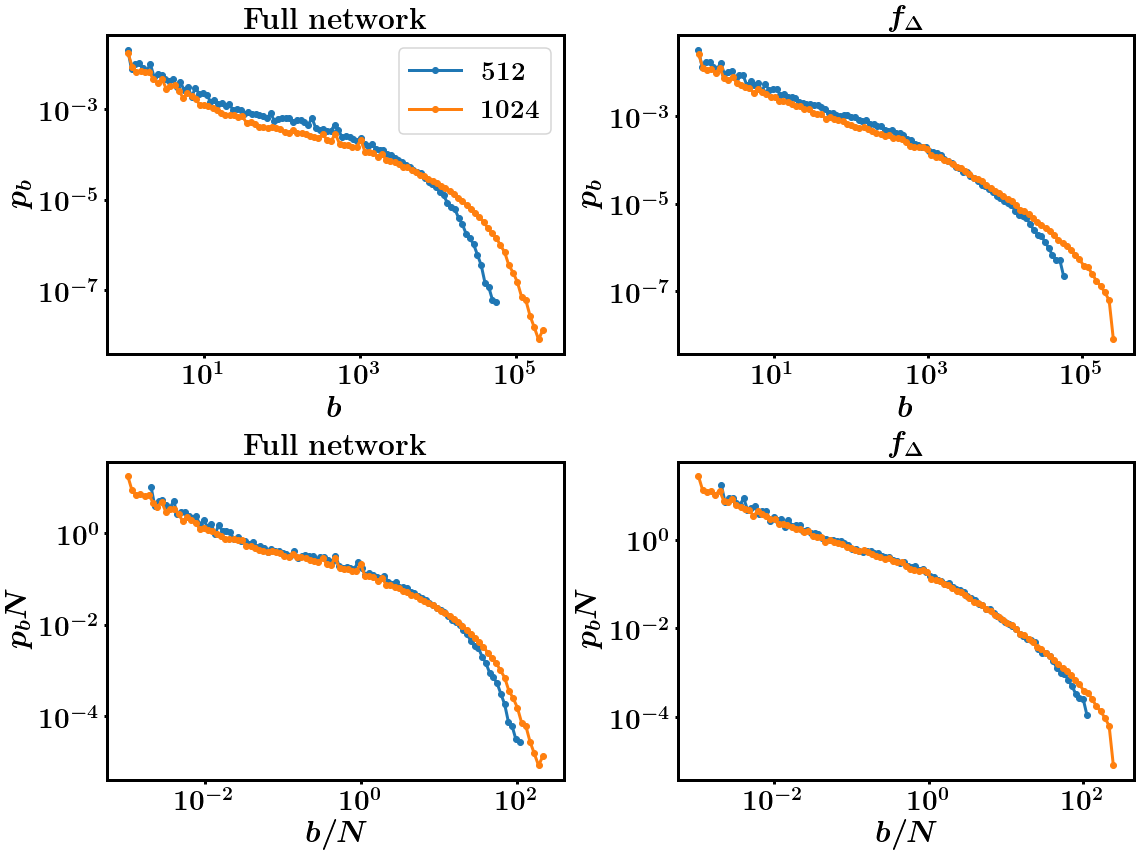

In [32]:
net_type = 'MR'
linestyles = ['-', '--']
markers = ['o', 's']

ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)

for ax in axes[0,:]:
    ax.set_xlabel(r'$b$')
    ax.set_ylabel(r'$p_b$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_xlim(0.8, 2e7)
    #ax.set_ylim(5e-11, 1e-2)
    
for ax in axes[1,:]:
    ax.set_xlabel(r'$b/N$')
    ax.set_ylabel(r'$p_b N$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_xlim(8e-5, 3e3)
    #ax.set_ylim(2e-7, 20)

times = ['initial', 'rc_Btw']
titles = [r'$\mathrm{Full\;network}$', r'$f_{\Delta}$']

density = True
for k in range(2):
    for i, size in enumerate(sizes):
        for j, time in enumerate(times):
            if j == 2:
                continue
                j = 1
            ax = axes[k][j]
            ax.set_title(titles[j], fontsize=30)
            btw_dist = btw_dist_dict[net_type][time][size]
            _btw_dist = btw_dist[btw_dist>0]
            bins = np.logspace(0, np.log10(_btw_dist.max()+1), 100)
            freq, bin_edges = np.histogram(_btw_dist, bins=bins, density=density)
            bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

            if not density:
                freq = freq / (freq.sum() * np.diff(bin_edges))

            X = bin_centers
            Y = freq

            if k == 1:
                n = size
                #rc = rc_values[i]
                #n = size * rc
                X = bin_centers / n
                Y = freq * n

            ax.plot(
                X, Y, 
                '-o',
                #linestyle=linestyles[j], marker=markers[j], 
                color=f'C{i}', label=r'${{{}}}$'.format(size)
            )
    
axes[0,0].legend()
plt.tight_layout()
fig_dir = '../draft/figs'
fig_name = os.path.join(fig_dir, '{}_btwDist_B'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

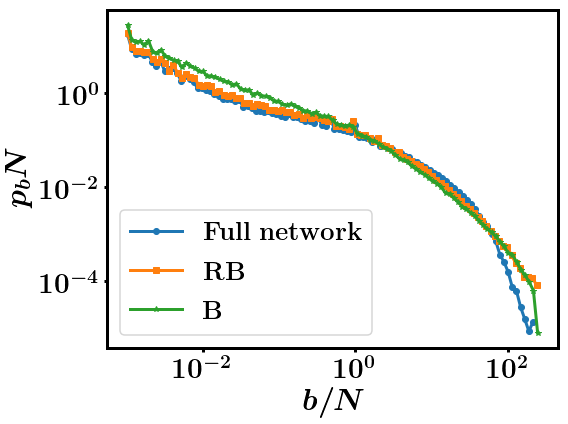

In [33]:
linestyles = ['-', '--']
markers = ['o', 's', '*']

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)

ax.set_xlabel(r'$b/N$')
ax.set_ylabel(r'$p_b N$')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(8e-5, 3e3)
#ax.set_ylim(2e-7, 20)

times = ['initial', 'rc_BtwU', 'rc_Btw']
labels = [r'$\mathrm{Full\;network}$', r'$\mathrm{RB}$', r'$\mathrm{B}$']

density = True
size = 1024
for j, time in enumerate(times):

    btw_dist = btw_dist_dict[net_type][time][size]
    _btw_dist = btw_dist[btw_dist>0]
    bins = np.logspace(0, np.log10(_btw_dist.max()+1), 100)
    freq, bin_edges = np.histogram(_btw_dist, bins=bins, density=density)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    X = bin_centers
    Y = freq

    n = size
    X = bin_centers / n
    Y = freq * n

    ax.plot(
        X, Y, 
        '-o',
        #linestyle=linestyles[j], 
        marker=markers[j], 
        label=labels[j]
    )
#ax.axvline(1, color='gray')
#ax.axvline(size, color='gray')
ax.legend()
plt.tight_layout()
fig_dir = '../draft/figs'
fig_name = os.path.join(fig_dir, '{}_btwDist_B_and_RB'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

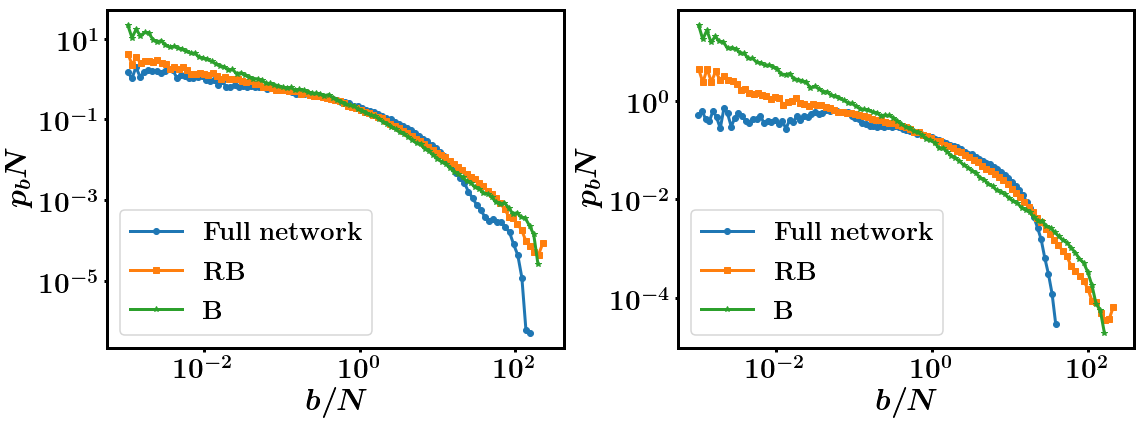

In [28]:
linestyles = ['-', '--']
markers = ['o', 's', '*']

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)

net_types = ['DT', 'PDT']
for i, net_type in enumerate(net_types):

    ax = axes[i]
    ax.set_xlabel(r'$b/N$')
    ax.set_ylabel(r'$p_b N$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_xlim(8e-5, 3e3)
    #ax.set_ylim(2e-7, 20)

    times = ['initial', 'rc_BtwU', 'rc_Btw']
    labels = [r'$\mathrm{Full\;network}$', r'$\mathrm{RB}$', r'$\mathrm{B}$']

    density = True
    size = 1024
    for j, time in enumerate(times):

        btw_dist = btw_dist_dict[net_type][time][size]
        _btw_dist = btw_dist[btw_dist>0]
        bins = np.logspace(0, np.log10(_btw_dist.max()+1), 100)
        freq, bin_edges = np.histogram(_btw_dist, bins=bins, density=density)
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

        X = bin_centers
        Y = freq

        n = size
        X = bin_centers / n
        Y = freq * n

        ax.plot(
            X, Y, 
            '-o',
            #linestyle=linestyles[j], 
            marker=markers[j], 
            label=labels[j]
        )
    ax.legend()
plt.tight_layout()
fig_dir = '../draft/figs'
#fig_name = os.path.join(fig_dir, '{}_btwDist_B_and_RB'.format(net_type))
#plt.savefig(fig_name + '.png')
#plt.savefig(fig_name + '.pdf')
plt.show()

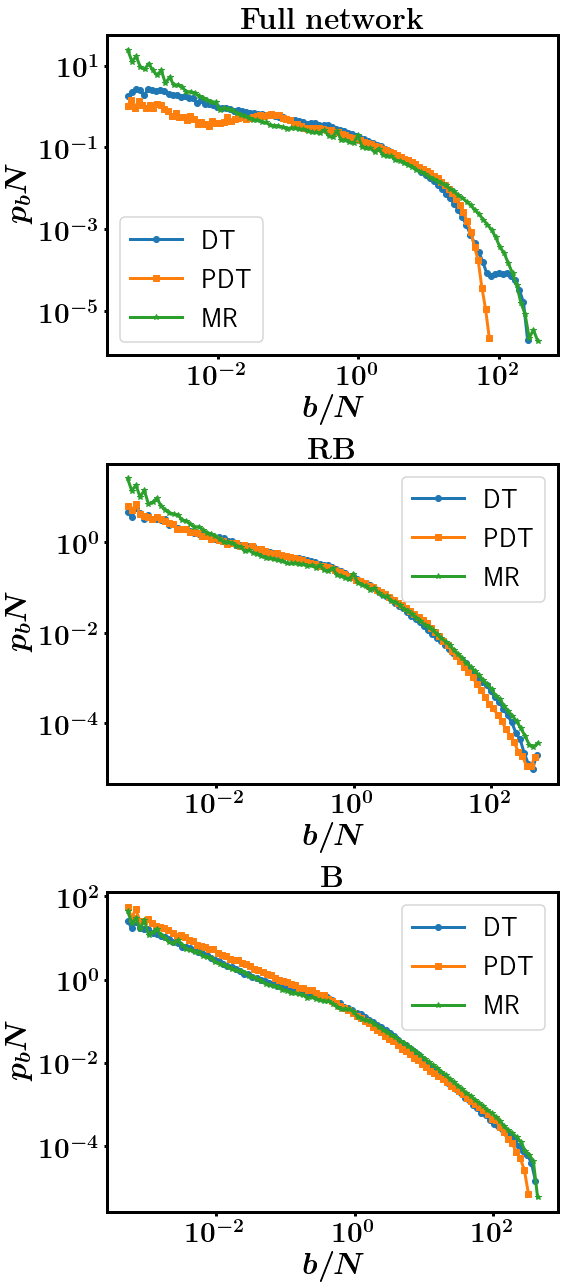

In [39]:
linestyles = ['-', '--']
markers = ['o', 's', '*']
times = ['initial', 'rc_BtwU', 'rc_Btw']
labels = [r'$\mathrm{Full\;network}$', r'$\mathrm{RB}$', r'$\mathrm{B}$']
size = 2048

net_types = ['DT', 'PDT', 'MR']
nrows = len(net_types)
ncols = 1
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)
    
for j, time in enumerate(times):
    ax = axes[j]
    ax.set_title(labels[j], fontsize=30)
    ax.set_xlabel(r'$b/N$')
    ax.set_ylabel(r'$p_b N$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_xlim(8e-5, 3e3)
    #ax.set_ylim(2e-7, 20)
    for i, net_type in enumerate(net_types):

        btw_dist = btw_dist_dict[net_type][time][size]
        _btw_dist = btw_dist[btw_dist>0]
        bins = np.logspace(0, np.log10(_btw_dist.max()+1), 100)
        freq, bin_edges = np.histogram(_btw_dist, bins=bins, density=True)
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

        X = bin_centers
        Y = freq

        n = size
        X = bin_centers / n
        Y = freq * n

        ax.plot(
            X, Y, 
            '-o',
            #linestyle=linestyles[j], 
            marker=markers[i], 
            label=net_types[i]
        )
    ax.legend()
plt.tight_layout()
fig_dir = '../draft/figs'
#fig_name = os.path.join(fig_dir, '{}_btwDist_B_and_RB'.format(net_type))
#plt.savefig(fig_name + '.png')
#plt.savefig(fig_name + '.pdf')
plt.show()